# **Лабораторная работа 1: «Метод обратного распространения ошибки»**

Подключаем все необходимые библиотеки

In [1]:
from matplotlib import pyplot as plot
import numpy as np
import time

Зададим набор параметров для демонстрации работы нейронной сети

In [2]:
# количество нейронов в сетке во входном слое
w = 28
h = 28
# количество нейронов в выходном слое
k = 10
# размер пачки может меняться от 8 до 64 изображений (в зависимости от доступного объема памяти)
batchSize = 64
# скорость обучения
learningRate = 0.1
# количество скрытых нейронов
s = 300
# Количество эпох
epochsCount = 20

Загружаем рукописные цифры из набора данных MNIST

In [24]:
with open("/content/train-images.idx3-ubyte", 'rb') as f:
        imagesTrain = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, w, h)
with open("/content/train-labels.idx1-ubyte", 'rb') as f:
        labelsTrain = np.frombuffer(f.read(), np.uint8, offset=8)
with open("/content/t10k-images.idx3-ubyte", 'rb') as f:
        imagesTest = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, w, h)
with open("/content/t10k-labels.idx1-ubyte", 'rb') as f:
        labelsTest = np.frombuffer(f.read(), np.uint8, offset=8)

Задаём функцию для вывода картинок с подписями

In [5]:
def showImages(title, images, labels):
    imgsCount = 6

    fig, axes = plot.subplots(imgsCount, imgsCount)
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks=[], yticks=[])

    for i, axes in enumerate(axes.flat):
        axes.imshow(images[i], cmap = 'gray')
        axes.text(0, 5, str(labels[i]), color = 'white')

Количество тренировочных данных: 60000
Количество тестовых данных: 10000


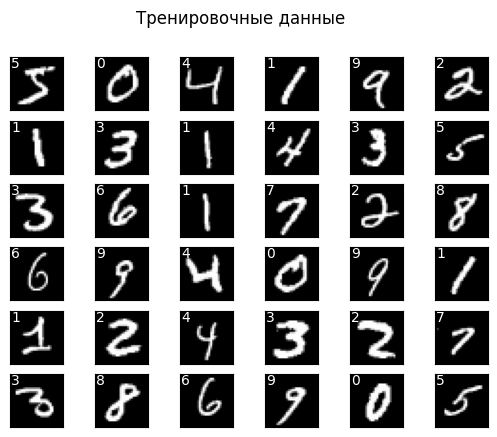

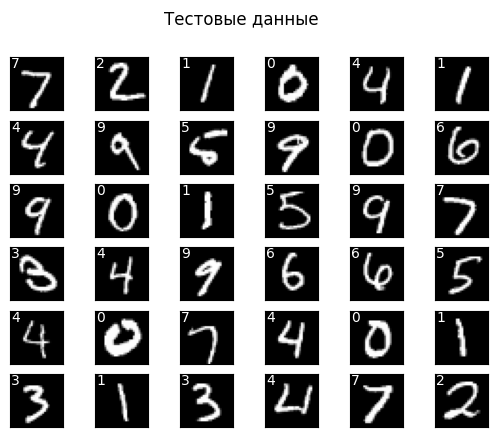

In [6]:
print('Количество тренировочных данных:', len(imagesTrain))
print('Количество тестовых данных:', len(imagesTest))

showImages('Тренировочные данные', imagesTrain, labelsTrain)
showImages('Тестовые данные', imagesTest, labelsTest)

В качестве функции активации на скрытом слое используется функция ReLU:

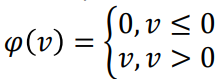

In [7]:
def ReLU(v):
    return np.maximum(v, 0)

В качестве функции активации на выходном слое используется функция softmax:

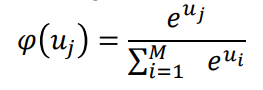

In [8]:
def softmax(u):
    return np.exp(u) / np.sum(np.exp(u), axis=1, keepdims=True)

В качестве функции ошибки используется кросс-энтропия:

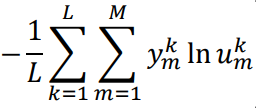

In [10]:
def crossEntropy(u, y):
    return np.mean(- 1 * y * np.log(u))

Зададим функцию для подсчёта точности:

In [11]:
def accuracy(y, u):
  return np.mean(np.argmax(u, axis = 1) == np.argmax(y, axis = 1))

Создаём класс для задания нейронной сети:

In [22]:
class NeuralNetwork():
    def __init__(self, inputLayer, hiddenLayer, outputLayer, learningRate):
        # инициализация синаптических весов
        self.w1 =  np.random.randn(inputLayer, hiddenLayer) * 0.02
        self.w2 = np.random.randn(hiddenLayer, outputLayer) * 0.02

        # задаём смещения
        self.b1 = np.zeros((1, hiddenLayer))
        self.b2 = np.zeros((1, outputLayer))

    #Прямой проход:
    #1. Вычисление значений выходных сигналов нейронов всех слоев
    #2. Вычисление значений функций активации на каждом слое сети
    def forward(self, x):
        self.f = np.dot(x, self.w1) + self.b1
        self.v = ReLU(self.f)
        self.g = np.dot(self.v, self.w2) + self.b2
        self.u = softmax(self.g)
        return self.u

    #Обратный проход:
    #1. Вычисление значения целевой функции и ее градиента
    #2. Корректировка синаптических весов
    def backward(self, x, y):
      # ошибка на выходном слое
      delta2 = (self.u - y)/len(self.u)
      # градиент для w2
      dw2 = np.dot(self.v.T, delta2)
      # производная ReLU
      dReLU = np.where(self.f > 0, 1, 0)
      # ошибка на скрытом слое
      delta1 = np.dot(delta2, self.w2.T) * dReLU
      # градиент для w1
      dw1 = np.dot(x.T, delta1)

      #градиенты для b1 и b2
      db2 = np.sum(delta2, axis=0, keepdims=True)
      db1 = np.sum(delta1, axis=0, keepdims=True)

      # корректировка весов(двигаемся в направлении антиградиента)
      self.w2 -= learningRate * dw2
      self.w1 -= learningRate * dw1
      self.b1 -= learningRate * db1
      self.b2 -= learningRate * db2

Тренеруем нейронку по эпохам с применением мини-пакетов

In [19]:
def train(network, x, y, epochsCount, batchSize):
    startTime = time.time()
    for epoch in range(epochsCount):
      for batch in range(0, len(x), batchSize):
        batchX = x[batch : batch + batchSize]
        batchY = y[batch : batch + batchSize]

        network.forward(batchX)
        network.backward(batchX, batchY)

      print(epoch + 1, "эпоха: ", "точность = {:.3f}".format(accuracy(y, network.forward(x))))
    print("общее время обучения: {:.3f}".format((time.time() - startTime) / 60), "минут")

In [25]:
# смена размерности (матрица в вектор)
imagesTrain = imagesTrain.reshape(-1, w * h)
imagesTest = imagesTest.reshape(-1, w * h)

# преобразование типа + делим на 255, чтобы значения лежали в диапозоне от 0 до 1
imagesTrain = imagesTrain.astype('float32') / 255
imagesTest = imagesTest.astype('float32') / 255

# преобразование ответов
labelsTrainVector = np.eye(k)[labelsTrain]
labelsTestVector = np.eye(k)[labelsTest]

In [26]:
net = NeuralNetwork(w*h, s, k, learningRate)
train(net, imagesTrain, labelsTrainVector, epochsCount, batchSize)

1 эпоха:  точность = 0.919
2 эпоха:  точность = 0.944
3 эпоха:  точность = 0.957
4 эпоха:  точность = 0.965
5 эпоха:  точность = 0.971
6 эпоха:  точность = 0.975
7 эпоха:  точность = 0.979
8 эпоха:  точность = 0.981
9 эпоха:  точность = 0.983
10 эпоха:  точность = 0.985
11 эпоха:  точность = 0.987
12 эпоха:  точность = 0.988
13 эпоха:  точность = 0.989
14 эпоха:  точность = 0.990
15 эпоха:  точность = 0.991
16 эпоха:  точность = 0.992
17 эпоха:  точность = 0.993
18 эпоха:  точность = 0.994
19 эпоха:  точность = 0.994
20 эпоха:  точность = 0.995
общее время обучения: 1.761 минут


In [27]:
print("Точность на тестовой выборке = {:.3f}".format(accuracy(labelsTestVector, net.forward(imagesTest))))

Точность на тестовой выборке = 0.980
